# Create parquet files for analysis

## Imports

In [1]:
import easysnowdata
import pystac_client
import tqdm
import planetary_computer
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
import odc.stac
import pathlib
import dask
import dask.distributed
import coiled
import matplotlib.pyplot as plt
import xdem
import rasterio
import seaborn as sns
import dask.dataframe as dd
from global_snowmelt_runoff_onset.config import Config, Tile

/home/eric/.local/lib/python3.10/site-packages/paramiko/pkey.py:100: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "cipher": algorithms.TripleDES,
/home/eric/.local/lib/python3.10/site-packages/paramiko/transport.py:259: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "class": algorithms.TripleDES,


In [2]:
config = Config('../config/global_config.txt')

Configuration loaded:
resolution = 0.00072000072000072
spatial_chunk_dim = 2048
bbox_left = -179.999
bbox_right = 179.999
bbox_top = 81.099
bbox_bottom = -59.999
wy_start = 2015
wy_end = 2024
low_backscatter_threshold = 0.001
min_monthly_acquisitions = 2
max_allowed_days_gap_per_orbit = 30
min_years_for_median_std = 3
valid_tiles_geojson_path = ../processing/valid_tiles.geojson
tile_results_path = ../processing/tile_results.csv
global_runoff_zarr_store_azure_path = snowmelt/snowmelt_runoff_onset/global.zarr
seasonal_snow_mask_zarr_store_azure_path = snowmelt/snow_mask_v2/global_modis_snow_mask.zarr


## Read global product

In [3]:
global_ds = xr.open_zarr(config.global_runoff_store, consolidated=True,decode_coords='all')

## Clip global product and reproject to UTM zone 

In [4]:
def add_coordinate_arrays(ds):
    """
    Create additional arrays to store original lat/lon coordinates.
    """
    lat, lon = np.meshgrid(ds.latitude, ds.longitude)
    ds['original_lat'] = xr.DataArray(lat.T, dims=('latitude', 'longitude'))
    ds['original_lon'] = xr.DataArray(lon.T, dims=('latitude', 'longitude'))
    return ds

## Rearrange data variables

In [5]:
def convert_water_year_dim_to_var(ds):
    for year in ds.water_year.values:
        ds[f'runoff_onset_WY{year}'] = ds['runoff_onset'].sel(water_year=year)

    ds = ds.drop_vars('runoff_onset').drop_vars('water_year')
    return ds

## Bring in variables: elevation, aspect, slope, tpi, snow class, esa worldcover, forest cover fraction... 

In [6]:
def add_topography(tile,ds):
    catalog = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1",modifier=planetary_computer.sign_inplace)
    search = catalog.search(collections=[f"cop-dem-glo-30"],intersects=tile.geobox.geographic_extent)
    dem_da = odc.stac.load(items=search.items(),like=ds,chunks={},resampling='bilinear')['data'].squeeze()
    dem_da = dem_da.rio.write_nodata(-32767,encoded=True).drop_vars('time').compute() # compute for xdem stuff

    ds['dem'] = dem_da

    # [xDEM](https://xdem.readthedocs.io/en/stable/index.html) to calculate slope and aspect and topographic position index

    attributes = xdem.terrain.get_terrain_attribute(
        ds['dem'],
        resolution=ds['dem'].rio.resolution()[0],
        attribute=["aspect", "slope", "topographic_position_index"],
    )

    ds['aspect'] = xr.DataArray(attributes[0], dims=ds['dem'].dims, coords=ds['dem'].coords)
    ds['slope'] = xr.DataArray(attributes[1], dims=ds['dem'].dims, coords=ds['dem'].coords)
    # TPI? https://xdem.readthedocs.io/en/stable/gen_modules/xdem.DEM.topographic_position_index.html, https://tc.copernicus.org/articles/8/1989/2014/tc-8-1989-2014.pdf
    # maybe incorrect radius...
    ds['tpi'] = xr.DataArray(attributes[2], dims=ds['dem'].dims, coords=ds['dem'].coords)

    # DAH?
    # alpha_max = 202.5 #only in northern hemisphere at specific latitude?
    # DAH_da = np.cos(np.deg2rad(alpha_max-aspect_da))*np.arctan(np.deg2rad(slope_da))

    return ds

def add_chili(tile,ds):

    chili_da = easysnowdata.topography.get_chili(tile.bbox_gdf)
    ds['chili'] = chili_da.rio.reproject_match(ds['dem'],resampling=rasterio.enums.Resampling.bilinear)

    return ds

def add_snow_class(tile,ds):

    snow_classification = easysnowdata.remote_sensing.get_seasonal_snow_classification(tile.bbox_gdf, mask_nodata=True)
    ds['snow_classification'] = snow_classification.rio.reproject_match(ds['dem'],resampling=rasterio.enums.Resampling.mode)

    return ds

def add_esa_worldcover(tile,ds):

    esa_worldcover = easysnowdata.remote_sensing.get_esa_worldcover(tile.bbox_gdf, mask_nodata=True)
    ds['esa_worldcover'] = esa_worldcover.rio.reproject_match(ds['dem'],resampling=rasterio.enums.Resampling.mode)

    return ds

def add_forest_cover(tile,ds):

    forest_cover_fraction = easysnowdata.remote_sensing.get_forest_cover_fraction(tile.bbox_gdf, mask_nodata=True)
    ds['forest_cover_fraction'] = forest_cover_fraction.rio.reproject_match(ds['dem'],resampling=rasterio.enums.Resampling.bilinear)

    return ds

In [7]:
# recalc median, std, nmad, trend, trend strength (use diff thresholds?)

## Convert dataset with all variables to dataframe where each pixel location is a row

In [8]:
def dataset_to_dataframe(tile,ds):
    # only drop row values / a pixel if there are no runoff_onset_predictions for any of the years
    # drop_subset = [f'runoff_onset_WY{water_year}' for water_year in water_years]

    #df = ds.to_dataframe().reset_index().dropna(subset=drop_subset,how='all').drop_vars('spatial_ref', axis=1) use this if we want to keep pixels with runoff_onset_predictions for two or less years, for three or more use next line
    df = ds.to_dataframe().reset_index().dropna(subset='runoff_onset_median').drop('spatial_ref', axis=1)

    df['tile_row'] = tile.row
    df['tile_col'] = tile.col
    hemisphere = 'northern' if ds.rio.crs.to_epsg() < 32700 else 'southern'
    df['hemisphere'] = hemisphere
    # change these as we include/exclude new vars
    df = df[["tile_row","tile_col","hemisphere","original_lat","original_lon","runoff_onset_WY2015","runoff_onset_WY2016","runoff_onset_WY2017","runoff_onset_WY2018","runoff_onset_WY2019","runoff_onset_WY2020","runoff_onset_WY2021","runoff_onset_WY2022","runoff_onset_WY2023","runoff_onset_WY2024","runoff_onset_median","runoff_onset_std","dem","aspect","slope","tpi","chili","snow_classification","esa_worldcover","forest_cover_fraction"]]
    
    columns_to_round = [col for col in df.columns if col not in ['original_lat', 'original_lon', 'runoff_onset_std', 'hemisphere']]
    df[columns_to_round] = df[columns_to_round].replace([np.inf, -np.inf, np.nan], -9999)
    df[columns_to_round] = df[columns_to_round].round().astype(int)

    df['original_lat'] = df['original_lat'].round(4)
    df['original_lon'] = df['original_lon'].round(4)
    df['runoff_onset_std'] = df['runoff_onset_std'].round(2)

    for col in df.columns:
        if df[col].dtype == 'int64':
            df[col] = pd.to_numeric(df[col], downcast='integer')
        elif df[col].dtype == 'float64':
            df[col] = pd.to_numeric(df[col], downcast='float')
    
    return df

## Put it all together

In [9]:
def create_utm_datacube(tile, global_ds):
    tile_ds = global_ds.rio.clip_box(*tile.get_geobox().boundingbox,crs='EPSG:4326')
    tile_ds = add_coordinate_arrays(tile_ds)
    utm_crs = tile_ds.rio.estimate_utm_crs()
    tile_utm_ds = tile_ds.rio.reproject(utm_crs,resolution=80,resampling=rasterio.enums.Resampling.bilinear).persist()
    tile_utm_ds = convert_water_year_dim_to_var(tile_utm_ds)
    tile_utm_ds = add_topography(tile,tile_utm_ds)
    tile_utm_ds = add_chili(tile,tile_utm_ds)
    tile_utm_ds = add_snow_class(tile,tile_utm_ds)
    tile_utm_ds = add_esa_worldcover(tile,tile_utm_ds)
    tile_utm_ds = add_forest_cover(tile,tile_utm_ds)
    return tile_utm_ds

In [10]:
def create_and_save_analysis_parquet(tile, filename, filesystem, global_ds):
    print(f"Processing {filename}")
    try:
        tile_utm_ds = create_utm_datacube(tile, global_ds)
        tile_utm_df = dataset_to_dataframe(tile, tile_utm_ds)
        tile_utm_df.to_parquet(f"snowmelt/analysis/tiles/{filename}",filesystem=filesystem)
        print(f"Saved {filename}")
        return filename, True
    except Exception as e:
        print(f"Error processing {filename}: {e}")
        return filename, False

## get tiles

In [11]:
config.valid_tiles_gdf.explore(column='success')

In [12]:
tile = Tile(14,27)
#tile = Tile(1,132)
tile.geobox.explore(tiles='EsriWorldImagery')

In [13]:
tile_utm_ds = create_utm_datacube(tile, global_ds)
tile_utm_ds

/home/eric/miniconda3/envs/global_snowmelt_runoff_onset/lib/python3.10/site-packages/xee/ext.py:685: UserWarning: Unable to retrieve 'system:time_start' values from an ImageCollection due to: No 'system:time_start' values found in the 'ImageCollection'.
  warnings.warn(


<xarray.Dataset> Size: 253MB
Dimensions:                (x: 1085, y: 2078)
Coordinates:
  * x                      (x) float64 9kB 5.448e+05 5.449e+05 ... 6.315e+05
  * y                      (y) float64 17kB 6.704e+06 6.704e+06 ... 6.538e+06
    spatial_ref            int64 8B 0
    band                   int64 8B 1
    time                   datetime64[ns] 8B 2021-01-01
Data variables: (12/22)
    runoff_onset_median    (y, x) float32 9MB nan nan nan nan ... nan nan nan
    runoff_onset_std       (y, x) float32 9MB nan nan nan nan ... nan nan nan
    original_lat           (y, x) float64 18MB nan nan nan nan ... nan nan nan
    original_lon           (y, x) float64 18MB nan nan nan nan ... nan nan nan
    runoff_onset_WY2015    (y, x) float32 9MB nan nan nan nan ... nan nan nan
    runoff_onset_WY2016    (y, x) float32 9MB nan nan nan nan ... nan nan nan
    ...                     ...
    slope                  (y, x) float64 18MB nan nan nan nan ... nan nan nan
    tpi                    (y, x) float64 18MB nan nan nan nan ... nan nan nan
    chili                  (y, x) float64 18MB nan nan nan nan ... nan nan nan
    snow_classification    (y, x) float32 9MB nan nan nan nan ... nan nan nan
    esa_worldcover         (y, x) float32 9MB nan nan nan nan ... nan nan nan
    forest_cover_fraction  (y, x) float32 9MB nan nan nan nan ... nan nan nan
Attributes:
    processed_tiles:  []

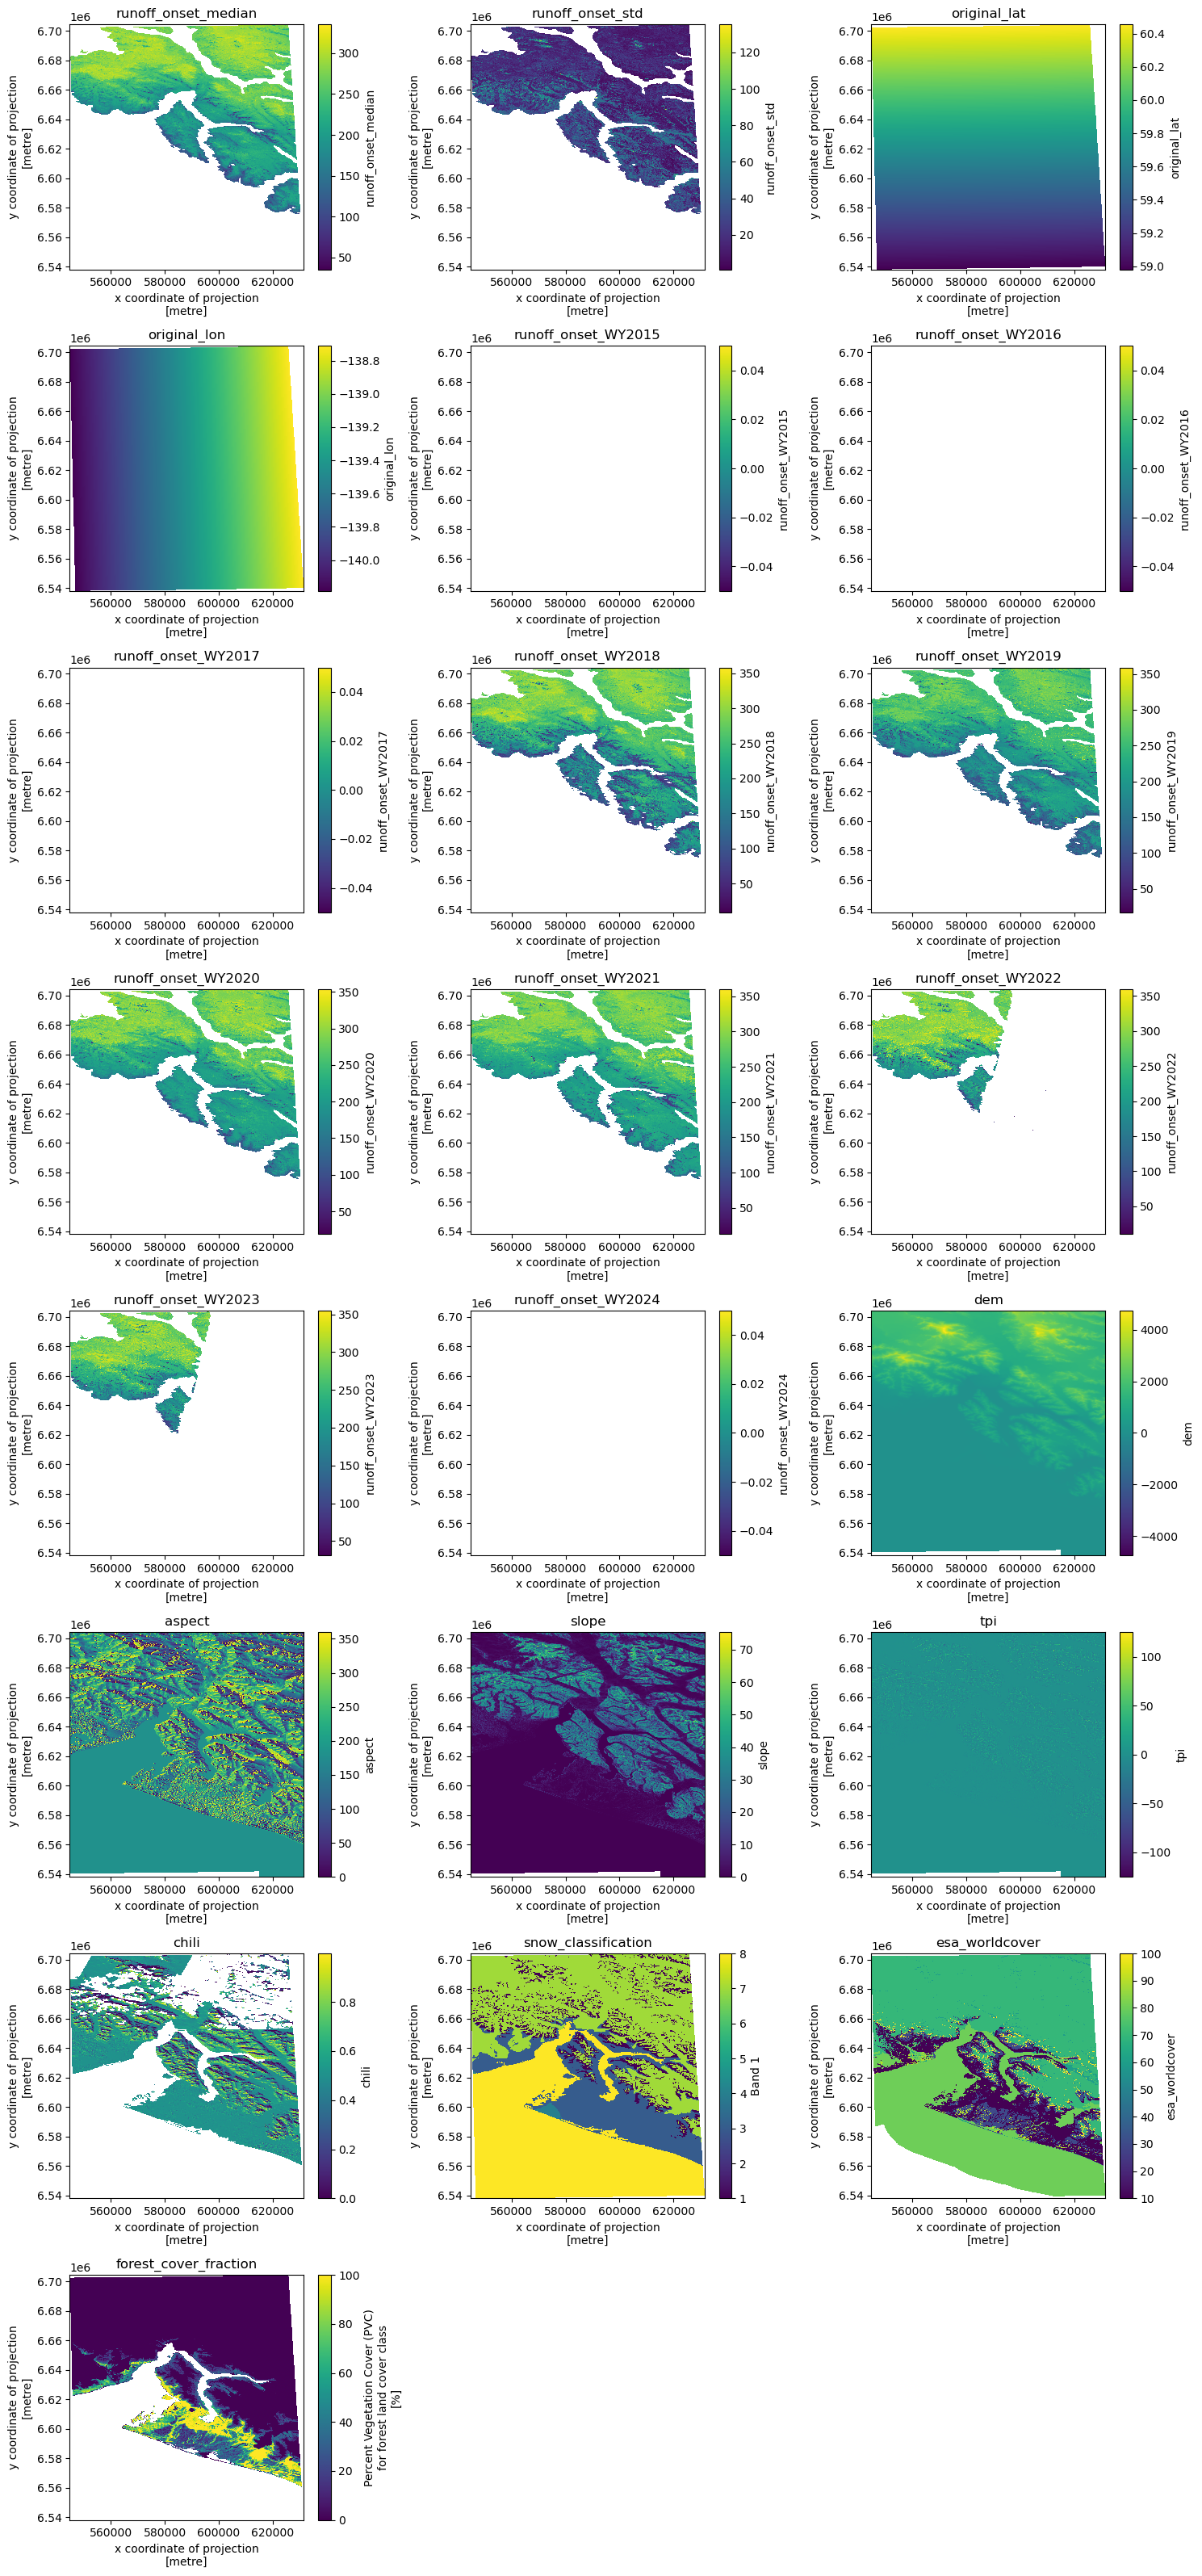

In [14]:
# Get the number of variables
n_vars = len(tile_utm_ds.data_vars)

# Calculate the number of rows and columns for the subplots
n_cols = 3  # You can adjust this number as needed
n_rows = (n_vars + n_cols - 1) // n_cols

# Create the figure and subplots
f,axs = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
axs = axs.flatten()  # Flatten the axes array for easy indexing

# Plot each variable
for i, (var_name, da) in enumerate(tile_utm_ds.data_vars.items()):
    da.plot(ax=axs[i], cmap='viridis')
    axs[i].set_title(var_name)

# Remove any unused subplots
for j in range(i+1, len(axs)):
    f.delaxes(axs[j])

f.tight_layout()

In [ ]:
tile_utm_df = dataset_to_dataframe(tile,tile_utm_ds)
tile_utm_df

## Write to files

In [ ]:
cluster = coiled.Cluster(idle_timeout="10 minutes",
                         n_workers=5,
                         worker_memory="64 GB",
                         worker_cpu=8,
                         scheduler_memory="32 GB",
                         spot_policy="spot",
                         environ={"GDAL_DISABLE_READDIR_ON_OPEN": "EMPTY_DIR"},
                         workspace="azure",
                         )

client = cluster.get_client()

In [ ]:
tiles = config.get_list_of_tiles(which='processed')

In [ ]:
try:
    existing_filenames = [pathlib.Path(path).name for path in config.azure_blob_fs.ls('snowmelt/analysis/tiles/')]
except:
    existing_filenames = []
        
futures = []

for tile in tqdm.tqdm(tiles,total=len(tiles)):

    filename = f'tile_{tile.row:03d}_{tile.col:03d}.parquet'

    if filename in existing_filenames:
        print(f'{filename} already exists, skipping...')
        continue

    future = client.submit(create_and_save_analysis_parquet, tile, filename, config.azure_blob_fs, global_ds, retries=1)
    futures.append(future)

In [ ]:
for future, result in dask.distributed.as_completed(futures, with_results=True):
    print(f"{result[0]} : {'SUCCESS' if result[1] == True else 'FAILED'}")

In [ ]:
parquet_files = config.azure_blob_fs.ls('snowmelt/analysis/tiles/')
parquet_files

## Code graveyard

In [ ]:
#view_tile(Tile(13,126)) very dense norway
#view_tile(Tile(1,133)) svalbard
#view_tile(Tile(88,72)) SA
#Tile(88,72).get_geobox().boundingbox
#test_ds = global_ds.rio.clip_box(-75,-51,-72,-48,crs='EPSG:4326') area surrounding SA tile, other tiles should be adjacenent
#f,ax=plt.subplots(2,1,figsize=(10,10))
#test_ds['runoff_onset_median'].plot.imshow(ax=ax[0],vmin=0,vmax=365)
#test_ds['runoff_onset_std'].plot.imshow(ax=ax[1],cmap='Reds')
#test_ds['runoff_onset'].plot.imshow(col='water_year',col_wrap=3,vmin=0,vmax=365)


# def view_tile(tile: Tile):


#     test_ds = global_ds.rio.clip_box(*tile.get_geobox().boundingbox,crs='EPSG:4326')

#     f,ax=plt.subplots(2,1,figsize=(10,10))
#     test_ds['runoff_onset_median'].plot.imshow(ax=ax[0],vmin=0,vmax=365)

#     test_ds['runoff_onset_std'].plot.imshow(ax=ax[1],cmap='Reds')

#     test_ds['runoff_onset'].plot.imshow(col='water_year',col_wrap=3,vmin=0,vmax=365)

In [ ]:
# tile_ds = global_ds.rio.clip_box(*tile.get_geobox().boundingbox,crs='EPSG:4326').compute()
# tile_ds

# tile_ds = add_coordinate_arrays(tile_ds)
# tile_ds
# utm_crs = tile_ds.rio.estimate_utm_crs()
# tile_utm_ds = tile_ds.rio.reproject(utm_crs,resolution=80,resampling=rasterio.enums.Resampling.bilinear)
# tile_utm_ds

# tile_utm_ds['runoff_onset'].plot.imshow(col='water_year',col_wrap=3,robust=True)

# f,axs = plt.subplots(1,2,figsize=(10,5))

# tile_utm_ds['runoff_onset_median'].plot.imshow(ax=axs[0],robust=True)
# tile_utm_ds['runoff_onset_std'].plot.imshow(ax=axs[1],robust=True,cmap='Reds')

# for ax in axs:
#     ax.set_aspect('equal')

# f,axs=plt.subplots(1,2,figsize=(10,5))
# tile_utm_ds['original_lat'].plot.imshow(ax=axs[0])
# tile_utm_ds['original_lon'].plot.imshow(ax=axs[1])
# axs[0].set_title('original_lat')
# axs[1].set_title('original_lon')

# for ax in axs:
#     ax.set_aspect('equal')

# tile_utm_ds = convert_water_year_dim_to_var(tile_utm_ds)
# tile_utm_ds
# tile_utm_ds = add_topography(tile,tile_utm_ds)
# tile_utm_ds
# tile_utm_ds = add_snow_class(tile,tile_utm_ds)
# tile_utm_ds
# tile_utm_ds = add_esa_worldcover(tile,tile_utm_ds)
# tile_utm_ds
# tile_utm_ds = add_forest_cover(tile,tile_utm_ds)
# tile_utm_ds
# tile_utm_df = dataset_to_dataframe(tile_utm_ds,utm_crs,water_years)
# tile_utm_df
# tile_results_df = pd.read_csv(f'results/tile_{tile.row:03d}_{tile.col:03d}.csv')


# var_list = ['runoff_onset_median','runoff_onset_std','aspect','slope','tpi','snow_classification','esa_worldcover','forest_cover_fraction']
# tile_utm_ds.hvplot.image(z=var_list,tiles="EsriImagery",crs=tile_utm_ds.rio.crs,width=500,height=500) # hover_cols=var_list


# num_vars = len(tile_utm_ds.data_vars)

# # Calculate the number of rows and columns for the subplots
# num_cols = 3  # You can adjust this
# num_rows = (num_vars + num_cols - 1) // num_cols

# # Create a figure with subplots
# fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 5*num_rows))
# axes = axes.flatten()  # Flatten the axes array for easy indexing

# # Loop through each variable and plot
# for i, (var_name, da) in enumerate(tile_utm_ds.data_vars.items()):
#     ax = axes[i]
#     da.plot(ax=ax)
#     ax.set_title(var_name)

# # Remove any unused subplots
# for j in range(i+1, len(axes)):
#     fig.delaxes(axes[j])

# # f,axs=plt.subplots(2,2,figsize=(10,10),sharex=True,sharey=True)


# # tile_utm_ds['dem'].plot.imshow(ax=axs[0,0])
# # tile_utm_ds['aspect'].plot.imshow(ax=axs[0,1],cmap='twilight')
# # tile_utm_ds['slope'].plot.imshow(ax=axs[1,0],cmap='Reds')
# # tile_utm_ds['tpi'].plot.imshow(ax=axs[1,1],cmap='Purples')

# # titles = ['DEM','Aspect','Slope','TPI']

# # for ax,title in zip(axs.flatten(),titles):
# #     ax.set_aspect('equal')
# #     ax.set_title(title)

# # f.tight_layout()
# # 
# # #hvplot.explorer(tile_utm_ds, x='x', y='y')
# # 
# # #hvplot.help("image")

# tile_utm_df.to_csv(f'results/tile_{tile.row:03d}_{tile.col:03d}.csv',index=False)